# Using the Infidelity errors (either from Calibration or a Noise Model) to make a changing circuit

In [49]:
def get_Infidelity(qubit_index, gate_name):
    """
    Returns the angle for the RX error gate.
    Logic: 
    - Faster gates (R) might have small over-rotations.
    - Two-qubit gates (CX) usually induce larger errors on both qubits.
    - specific qubits (e.g., q[4]) might be 'bad' qubits with higher error.
    """
    
    # Base error rates
    ## Replace with learned matrix later...
    if gate_name == 'cz0':
        base_error = 0.01 # Larger error for entangling gates
    elif gate_name == 'cz1':
        base_error = 0.1  # Larger error for entangling gates
    elif gate_name == 'r':
        base_error = 0.1  # Smaller error for single rotations
    elif gate_name == 'rz':
        base_error = 0 # Z-rotations are usually virtual and precise
    else:
        print(gate_name + ": Not a registered native gate...")
        return 0.0 # No error for other gates, flag if outside native gate set

    # Qubit specific multiplier (e.g., Qubit 4 is noisy)
    ## Make a matrix when have data
    qubit_multiplier = 1.5 if qubit_index == 4 else 1.0
    
    return base_error * qubit_multiplier

In [36]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import RXGate
import random
from math import pi

def add_BitFlips(original_qc: QuantumCircuit) -> QuantumCircuit:
    """
    Takes a clean QuantumCircuit and returns a new one with 
    coherent RX errors injected after every gate.
    """
    # 1. Create a new empty circuit
    noisy_qc = original_qc.copy_empty_like()
    
    ignore_ops = {'measure', 'barrier', 'reset', 'snapshot'}

    # 3. Iterate through the original instructions
    for instruction in original_qc.data:
        
        # A. Append the original gate
        noisy_qc.append(instruction)
        
        op_name = instruction.operation.name
        
        # B. Check if we should inject noise
        if op_name == 'cz':
            control_switch = 0
            for q in instruction.qubits:
                # --- FIX 1: Use find_bit(q).index ---
                q_idx = original_qc.find_bit(q).index
                
                current_infidelity = get_infidelity(q_idx, op_name + str(control_switch))
    
                if current_infidelity > random.random():
                    bit_flip = RXGate(pi)
                    noisy_qc.append(bit_flip, [q])
                    
                control_switch = 1

        elif op_name not in ignore_ops:
            
            # C. Inject RX error on *each* qubit involved
            for q in instruction.qubits:
                # --- FIX 1: Use find_bit(q).index ---
                q_idx = original_qc.find_bit(q).index

                current_infidelity = get_infidelity(q_idx, op_name)
                
                if current_infidelity > random.random():
                    bit_flip = RXGate(pi)
                    noisy_qc.append(bit_flip, [q])
                
    return noisy_qc

In [8]:
from qiskit import QuantumCircuit, transpile

def get_test_circuit(n_qubits=5):
    qc = QuantumCircuit(n_qubits)
    
    # 1. Create Superposition on the first qubit
    # (Tests single-qubit 'r' gate noise)
    qc.h(0)
    
    # 2. Entangle neighbors linearly (Chain)
    # (Tests two-qubit 'cx' crosstalk/ZZ noise)
    for i in range(n_qubits - 1):
        qc.cx(i, i+1)
        
    # 3. Measurement (Optional, depending on if your simulator needs it)
    qc.measure_all()
    
    return qc

# Generate and print
seed = 42
qc = get_test_circuit(5)

native_gates = ['r', 'rz', 'cz'] 

# 3. Transpile
# optimization_level=3 tries hardest to reduce gate count
circuit = transpile(qc, basis_gates=native_gates, optimization_level=3)
noisy_circuit = add_BitFlips(circuit)

circuit.draw("mpl")
noisy_circuit.draw("mpl")

NameError: name 'add_BitFlips' is not defined

In [13]:
ccc = get_test_circuit()
for q in ccc.qubits:
    print(q)

<Qubit register=(5, "q"), index=0>
<Qubit register=(5, "q"), index=1>
<Qubit register=(5, "q"), index=2>
<Qubit register=(5, "q"), index=3>
<Qubit register=(5, "q"), index=4>


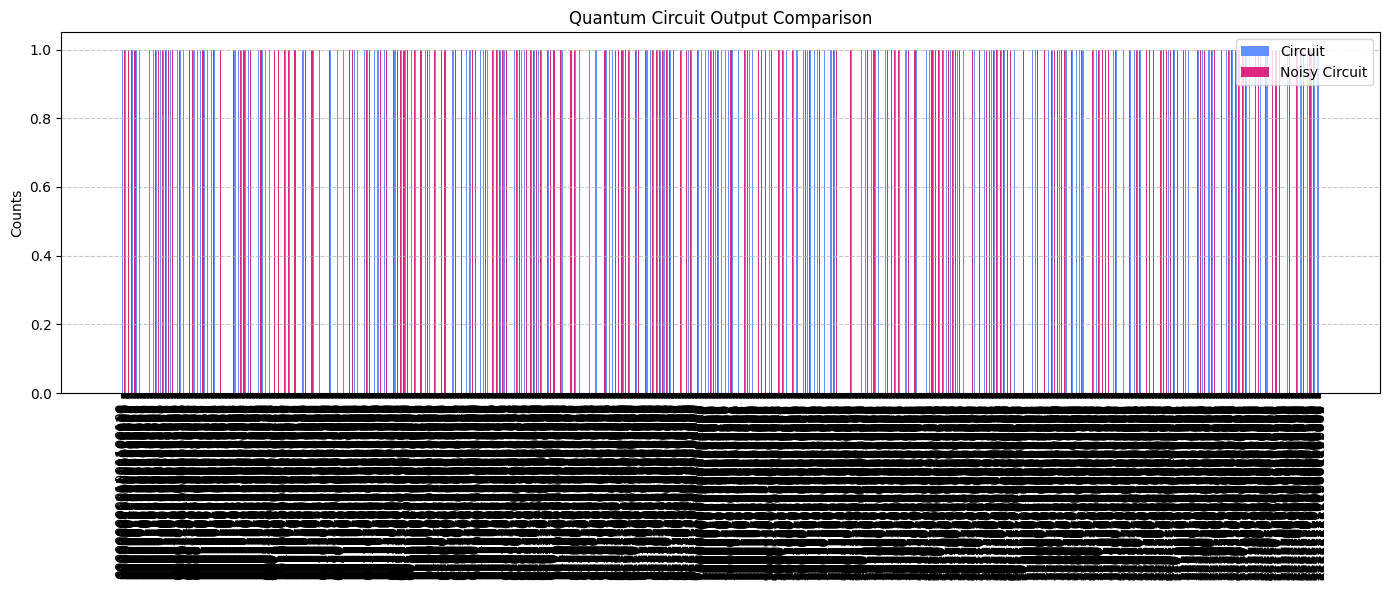

0.5022949218750046


In [2]:
from Qubit_Simulator import Hadamard_Simulator

print(Hadamard_Simulator(num_qubits = 20, shots = 1024))

In [16]:
from qiskit import QuantumCircuit, transpile
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
import numpy as np
from BitFlipper import add_BitFlips
import random

num_qubits = 5
native_gates = ['r', 'rz', 'cz']
shots = 1024
simulator = AerSimulator()
circ_seed = 312
sim_seed = 254

# Create GHZ circuit

qc = QuantumCircuit(num_qubits)
for i in range(num_qubits):
    qc.h(i)
 
qc.measure_all()

# Transpile to native gates
circuit = transpile(qc, basis_gates=native_gates, optimization_level=3)
noisy_circuit = add_BitFlips(circuit, seed = circ_seed)

# Run the circuit 
random.seed(sim_seed)
result = simulator.run(circuit, shots=shots, seed = sim_seed).result()
noisy_result = simulator.run(noisy_circuit, shots=shots, seed = sim_seed).result()

# 3. Get counts
counts = result.get_counts()
noisy_counts = noisy_result.get_counts()
print(counts)
print("\n")
print(sorted(list(set(counts.keys()))))
print("\n")

print([counts.get(key, 0) for key in sorted(list(set(counts.keys())))])

{'00100': 21, '00011': 40, '01110': 26, '10011': 30, '10110': 25, '00000': 27, '01011': 41, '11011': 28, '01001': 42, '00111': 42, '10100': 28, '11010': 31, '00001': 32, '10101': 28, '00101': 34, '01100': 35, '01000': 29, '10001': 32, '01111': 32, '10111': 28, '01101': 42, '11100': 39, '01010': 33, '11110': 35, '10010': 33, '11101': 28, '00110': 31, '11111': 22, '11000': 31, '11001': 28, '10000': 32, '00010': 39}


['00000', '00001', '00010', '00011', '00100', '00101', '00110', '00111', '01000', '01001', '01010', '01011', '01100', '01101', '01110', '01111', '10000', '10001', '10010', '10011', '10100', '10101', '10110', '10111', '11000', '11001', '11010', '11011', '11100', '11101', '11110', '11111']


[27, 32, 39, 40, 21, 34, 31, 42, 29, 42, 33, 41, 35, 42, 26, 32, 32, 32, 33, 30, 28, 28, 25, 28, 31, 28, 31, 28, 39, 28, 35, 22]


In [31]:
print(bit_counts[2])
print(bitstrings[2])

39
00010


In [25]:
# Example Data Setup
# (Assuming you already have these two lists)
bitstrings = sorted(list(set(counts.keys())))
bit_counts = [counts.get(key, 0) for key in sorted(list(set(counts.keys())))]

# 1. Initialize a list of zeros to hold the total for each of the 6 positions
digit_sums = [0] * 5

# 2. Iterate through both lists simultaneously using zip()
for b_str, count in zip(bitstrings, bit_counts):
    # 3. Loop through each character in the current bitstring
    for i, bit in enumerate(b_str):
        # 4. If the bit is '1', add the count to the total for that position
        if bit == '1':
            digit_sums[i] += count

# Output the results
print("Total counts per position:", digit_sums)

Total counts per position: [478, 522, 496, 516, 529]


In [1]:
from qiskit import QuantumCircuit, transpile
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
import numpy as np
from BitFlipper import add_BitFlips
import random

def Hadamard_Simulator(num_qubits = 5, native_gates = ['r', 'rz', 'cz'], shots = 1024, simulator = AerSimulator(), circ_seed = 312, sim_seed = 254):    
	# Create GHZ circuit
	
	qc = QuantumCircuit(num_qubits)
	for i in range(2,num_qubits):
		qc.h(i)
	 
	qc.measure_all()
	
	# Transpile to native gates
	circuit = transpile(qc, basis_gates=native_gates, optimization_level=3)
	noisy_circuit = add_BitFlips(circuit, seed = circ_seed)
	
	# Run the circuit 
	random.seed(sim_seed)
	result = simulator.run(circuit, shots=shots, seed = sim_seed).result()
	noisy_result = simulator.run(noisy_circuit, shots=shots, seed = sim_seed).result()
	
	# 3. Get counts
	counts = result.get_counts()
	noisy_counts = noisy_result.get_counts()
	
	all_keys = set(counts.keys()) | set(noisy_counts.keys())
	
	# Sort keys to ensure the X-axis is in binary order (00000 -> 11111)
	sorted_keys = sorted(list(all_keys))
	
	# Create lists of values aligned to the sorted keys
	# .get(key, 0) ensures we put a 0 if that bitstring didn't occur in a specific circuit
	values = [counts.get(key, 0) for key in sorted_keys]
	noisy_values = [noisy_counts.get(key, 0) for key in sorted_keys]
	
	# 3. Plotting
	x = np.arange(len(sorted_keys))  # The label locations
	width = 0.35  # The width of the bars
	
	fig, ax = plt.subplots(figsize=(14, 6)) # Wide figure to fit labels
	
	# Plot the two sets of bars, offset by +/- width/2
	rects1 = ax.bar(x - width/2, values, width, label='Circuit', color='#648FFF')
	rects2 = ax.bar(x + width/2, noisy_values, width, label='Noisy Circuit', color='#DC267F')
	
	# 4. Formatting
	ax.set_ylabel('Counts')
	ax.set_title('Quantum Circuit Output Comparison')
	ax.set_xticks(x)
	ax.set_xticklabels(sorted_keys, rotation=90) # Rotate labels for readability
	ax.legend()
	
	# Optional: Add grid for easier reading of height
	ax.grid(axis='y', linestyle='--', alpha=0.7)
	
	plt.tight_layout()
	plt.show()

	digit_sums = [0] * num_qubits
	
	for b_str, count in zip(sorted_keys, values):
	    for i, bit in enumerate(b_str):
	        if bit == '1':
	            digit_sums[i] += count
	
	# Output the results
	return digit_sums
